In [54]:
# import gdown
# from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
# from pyro.optim import Adam
# import os
# import pyro
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
import re
import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns
from datetime import datetime
import time
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
import skimage as skim
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler
from scipy import stats
# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
import gmmvae08 as M8
import gmmvae09 as M9
import gmmvae10 as M10
import gmmvae11 as M11
import gmmvae12 as M12
import gmmvae13 as M13
import gmmvae14 as M14
import gmmvae15 as M15
import gmmvae16 as M16
import gmmvaeBeta00 as Mb0
import gmmTraining as Train

print(torch.cuda.is_available())

plt.ion()
sc.settings.verbosity = 3
sc.logging.print_header()
# sc.settings.set_figure_params(dpi=120, facecolor='white', )
# sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white', )
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
)

True
scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.22.1 scipy==1.7.3 pandas==1.4.0 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [55]:
adata = sc.read_h5ad("./data/scgen/scGen_datasets/train_study.h5ad")
bdata = sc.read_h5ad("./data/scgen/scGen_datasets/valid_study.h5ad")

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [56]:
adata.X = adata.X.toarray()
bdata.X = bdata.X.toarray()

In [59]:
#sc.pp.scale(adata, max_value=10)
#sc.pp.scale(bdata, max_value=10)
#sc.pp.scale(adata, )
#sc.pp.scale(bdata, )
#bdata.X.sum(-1), adata.X.sum(-1)
adata.X.mean(0), adata.X.var(0), adata.X.max(), adata.X.min()

(array([0.00363745, 0.05727683, 0.11712319, ..., 0.0136309 , 0.00926703,
        0.1722148 ], dtype=float32),
 array([0.00285376, 0.04354751, 0.10428577, ..., 0.01065564, 0.00976564,
        0.11881868], dtype=float32),
 7.0673857,
 0.0)

In [60]:
enc_labels = LabelEncoder()
labels = enc_labels.fit_transform( adata.obs["cell_type"],)
labels = F.one_hot(torch.tensor(labels)).float()
enc_conds = LabelEncoder()
conditions = enc_conds.fit_transform(adata.obs["condition"],)
conditions = F.one_hot(torch.tensor(conditions)).float()
data = torch.tensor(adata.X)

test_enc_labels = LabelEncoder()
test_labels = test_enc_labels.fit_transform( bdata.obs["cell_type"],)
test_labels = F.one_hot(torch.tensor(test_labels)).float()
test_enc_conds = LabelEncoder()
test_conditions = test_enc_conds.fit_transform(bdata.obs["condition"],)
test_conditions = F.one_hot(torch.tensor(test_conditions)).float()
test_data = torch.tensor(bdata.X)


In [61]:
labeledSubset = ut.randomSubset(s=len(adata), r=0.45)
labeled_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [data[labeledSubset],
                labels[labeledSubset],
                conditions[labeledSubset],
                ],),
            batch_size=128,
            shuffle=True,
            )
unlabeled_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [data[~labeledSubset],
                labels[~labeledSubset],
                conditions[~labeledSubset],
                ],),
            batch_size=128,
            shuffle=True,
            )
test_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [test_data,
                test_labels,
                test_conditions,
                ],),
            batch_size=128,
            shuffle=True,
            )
train_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [data,
                labels,
                conditions,
                ],),
            batch_size=128,
            shuffle=True,
            )
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSet(
            data,
            labels,
                ),
            batch_size=128,
            shuffle=True,
            )

x,y,c = train_loader.__iter__().next()

In [66]:
model = Mb0.VAE_Dirichlet_GMM_TypeB1602xz(
        nx=adata.n_vars,
        nz=10,
        nw=10,
        nclasses=labels.shape[1]*4,
        concentration=1e0,
        dropout=0.15,
        bn=True,
        reclosstype="mse",
        restrict_w=True,
        restrict_z=True,
        #nc1=conditions.shape[1],
        #learned_prior=False,
        #learned_prior=True,
        )
model.apply(init_weights)
print(model.__class__)

<class 'gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602xz'>


In [67]:
Train.basicTrainLoop(
        model,
        data_loader,
        None,
        num_epochs=25,
        report_interval=25,
        lrs = [1e-3,1e-3,1e-4,1e-5,],
        #lrs = [1e-4,1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        test_accuracy=True,
        )

epoch's lr =  0.001
epoch 0
training phase
rec: 1368.3404541015625
loss_z: 15.01284408569336
loss_w: 5.19382381439209
loss_cluster: -0.17832010984420776
loss_d: 22.82075309753418
loss_y_alt: 1.707493543624878
loss_y_alt2: 0
total_loss: 1413.075439453125
num_clusters: 1

[-1. -1.  4.  2.  5. -1.  1. -1.  2.  5. -1. -1. -1.  3.  5. -1.  2. -1.
  6.  5. -1. -1.  1.  6.  5.  2. -1. -1.] 
 -0.09223503962024372 
 [-1.         -1.          1.          0.375       1.         -1.
  0.23076923 -1.          0.6122449   0.66666667 -1.         -1.
 -1.          0.33333333  1.         -1.          1.         -1.
  1.          0.6875     -1.         -1.          0.42857143  0.33333333
  0.75        1.         -1.         -1.        ]
0.6956521739130435 

epoch's lr =  0.001
epoch 0
training phase
rec: 215.41871643066406
loss_z: 3.1790666580200195
loss_w: 0.48272281885147095
loss_cluster: -0.7758059501647949
loss_d: 0.32049623131752014
loss_y_alt: 2.762763738632202
loss_y_alt2: 0
total_loss: 222.16375

In [69]:
model.cpu()
model.eval()
#output = model(test_data, cond1=test_conditions)
output = model(test_data, )

# not quite correct b/c it doesn't uses the conditional info
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
print(p, "\n", r.mean(), "\n", r)

[ 1.  2.  2.  5.  2.  2.  6.  2. -1. -1.  6.  2.  5.  2.  2.  2.  0.  0.
 -1. -1.  1.  2.  5. -1.  2. -1.  3.  2.] 
 0.42967348408672595 
 [ 0.45890411  0.77083333  0.98        0.74538745  0.89855072  0.96666667
  1.          0.90909091 -1.         -1.          0.78181818  0.92592593
  0.592       0.70422535  0.92982456  0.98666667  0.89        0.84172662
 -1.         -1.          0.92561983  0.95238095  0.69277108 -1.
  0.92156863 -1.          0.70689655  0.45      ]


In [100]:
rr = torch.tensor(
    [x for x in r if x>=0])
ss = torch.tensor(
    [x for x in s if x>=0])
#print(s,(r*s).sum() / s.sum())
ss
rr.mean()
ss.sum()
print((rr*ss).sum().item() / ss.sum().item(), rr.mean().item())


0.7945 0.8195844342921969


In [75]:
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()
bdata.obsm["z"] = output["mu_z"].detach().numpy()
bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))

In [73]:
#sc.pp.neighbors(bdata,use_rep="z")
sc.pp.neighbors(bdata,use_rep="z")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


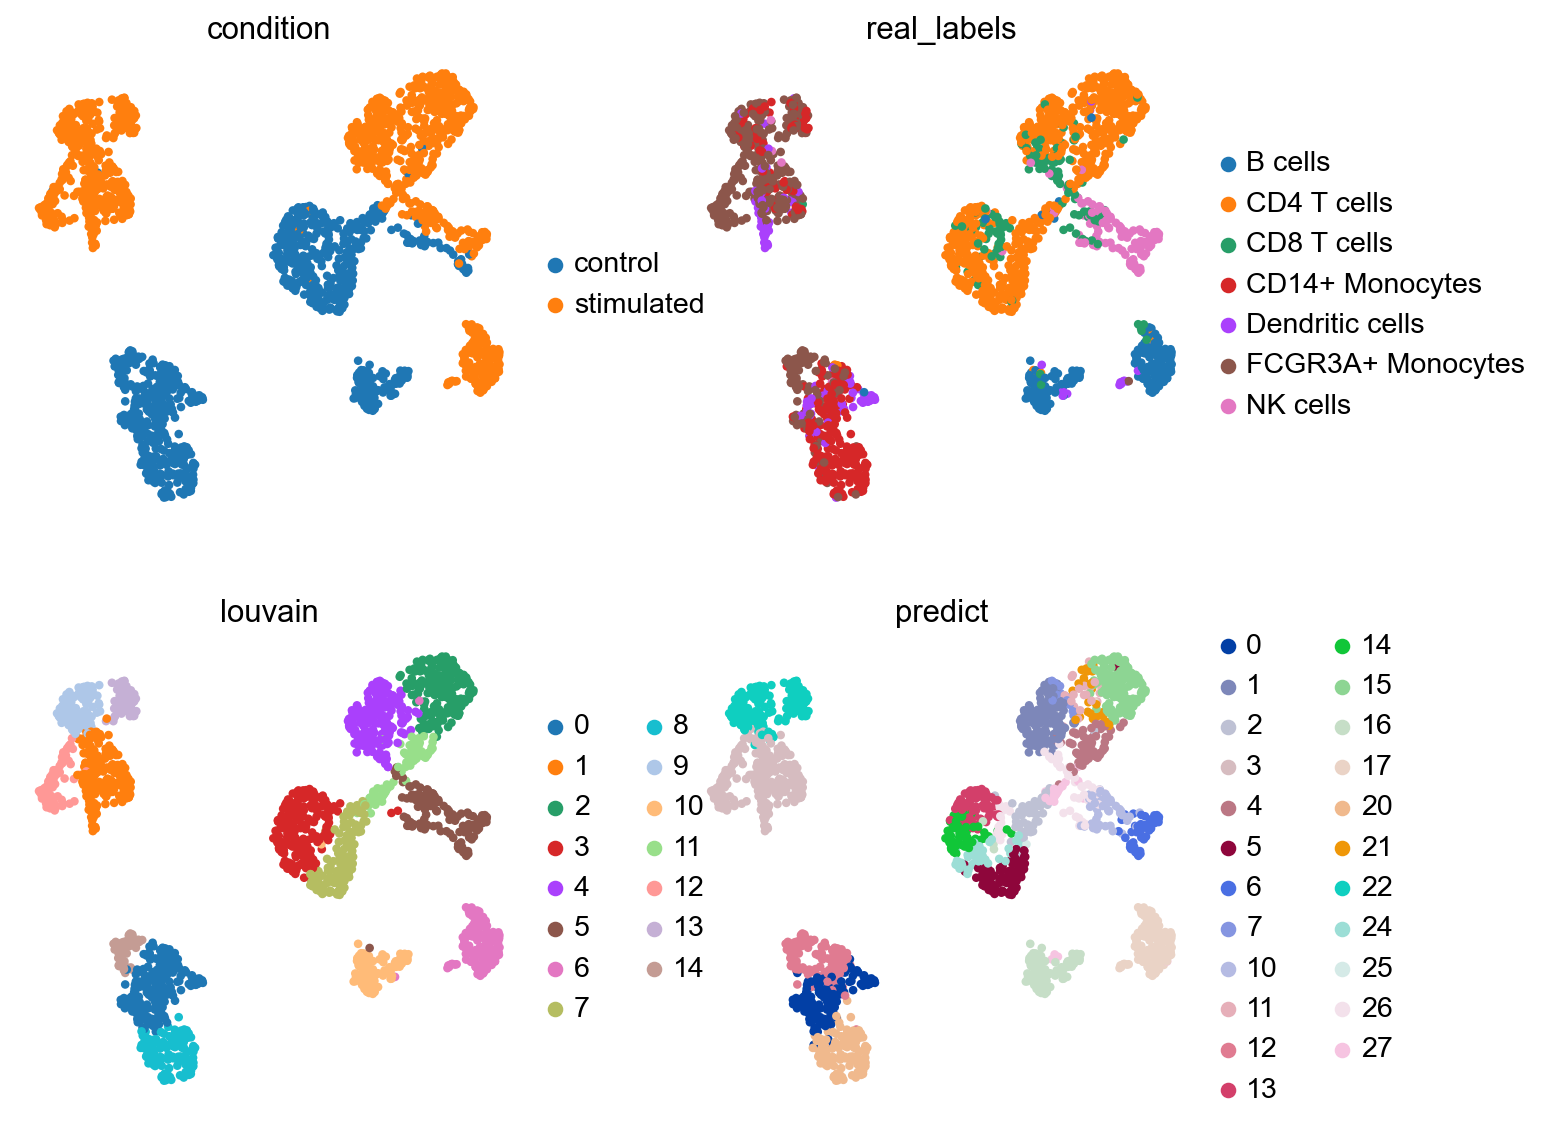

In [77]:
sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               "predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )


In [107]:
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [data,
                labels,
                conditions,
                ],),
            batch_size=128,
            shuffle=True,
)
#data_loader = torch.utils.data.DataLoader(
#        dataset = ut.SynteticDataSet(
#            data,
#            labels,
#                ),
#            batch_size=128,
#            shuffle=True,
#            )
#            )
data_loader.__class__
data__loader.dataset.__class__

my_torch_utils.SynteticDataSetV2

In [78]:
model = Mb0.VAE_Dirichlet_GMM_TypeB1602xzC(
        nx=adata.n_vars,
        nz=10,
        nw=10,
        nclasses=labels.shape[1]*2,
        concentration=1e0,
        dropout=0.15,
        bn=True,
        reclosstype="mse",
        restrict_w=True,
        restrict_z=True,
        nc1=conditions.shape[1],
        learned_prior=False,
        #learned_prior=True,
        )
model.apply(init_weights)
print(model.__class__)


<class 'gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602xzC'>


In [79]:
Train.basicTrainLoopCond(
        model,
        data_loader,
        None,
        num_epochs=25,
        report_interval=35,
        lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        test_accuracy=True,
        )


epoch's lr =  0.001
epoch 0
training phase
rec: 1369.5455322265625
loss_z: 18.291873931884766
loss_w: 4.585716247558594
loss_cluster: -0.24085921049118042
loss_d: 13.965912818908691
loss_y_alt: 1.9253216981887817
loss_y_alt2: 0
total_loss: 1408.3143310546875
num_clusters: 3

[ 1.  5.  2.  5.  1.  2.  2. -1.  2.  1.  2.  2.  2.  2.] 
 0.5433809410051647 
 [ 0.30434783  0.68        0.625       0.42857143  1.          1.
  0.5        -1.          0.6         0.75        0.8         0.71428571
  0.66666667  0.53846154]
0.5905511811023622 

epoch's lr =  0.001
epoch 0
training phase
rec: 211.76820373535156
loss_z: 3.5540900230407715
loss_w: 0.6937210559844971
loss_cluster: -0.9894374012947083
loss_d: 0.3997002840042114
loss_y_alt: 2.2493515014648438
loss_y_alt2: 0
total_loss: 218.66506958007812
num_clusters: 9

[ 5.  5.  2.  2.  1. -1. -1.  0. -1. -1.  0. -1.  5.  2.] 
 0.0473419437705152 
 [ 0.53333333  0.61538462  0.66666667  0.85714286  0.71428571 -1.
 -1.          0.5        -1.        

In [84]:
output = model(test_data, )
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()
bdata.obsm["z"] = output["mu_z"].detach().numpy()
bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))

In [85]:
#sc.pp.neighbors(bdata,use_rep="z")
sc.pp.neighbors(bdata,use_rep="z")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predict' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical


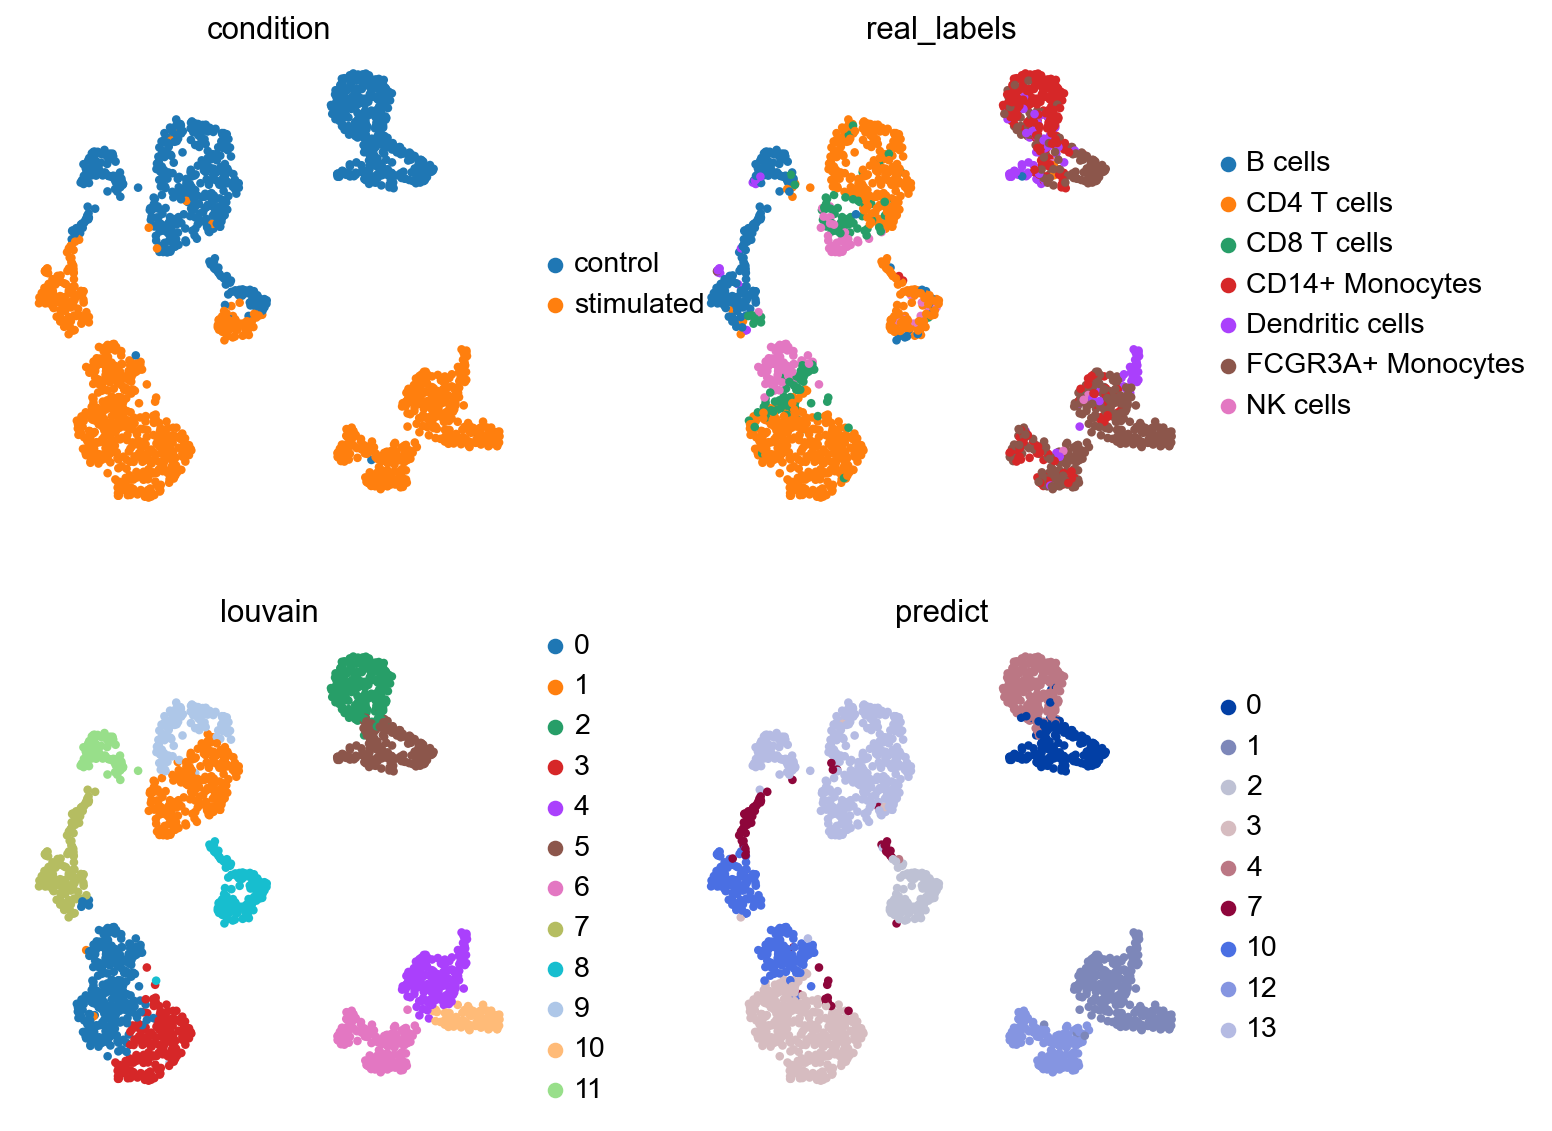

In [86]:
sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               "predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )

In [101]:
#sc.pp.neighbors(bdata,use_rep="z")
sc.pp.pca(bdata,)
sc.pp.neighbors(bdata,)
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


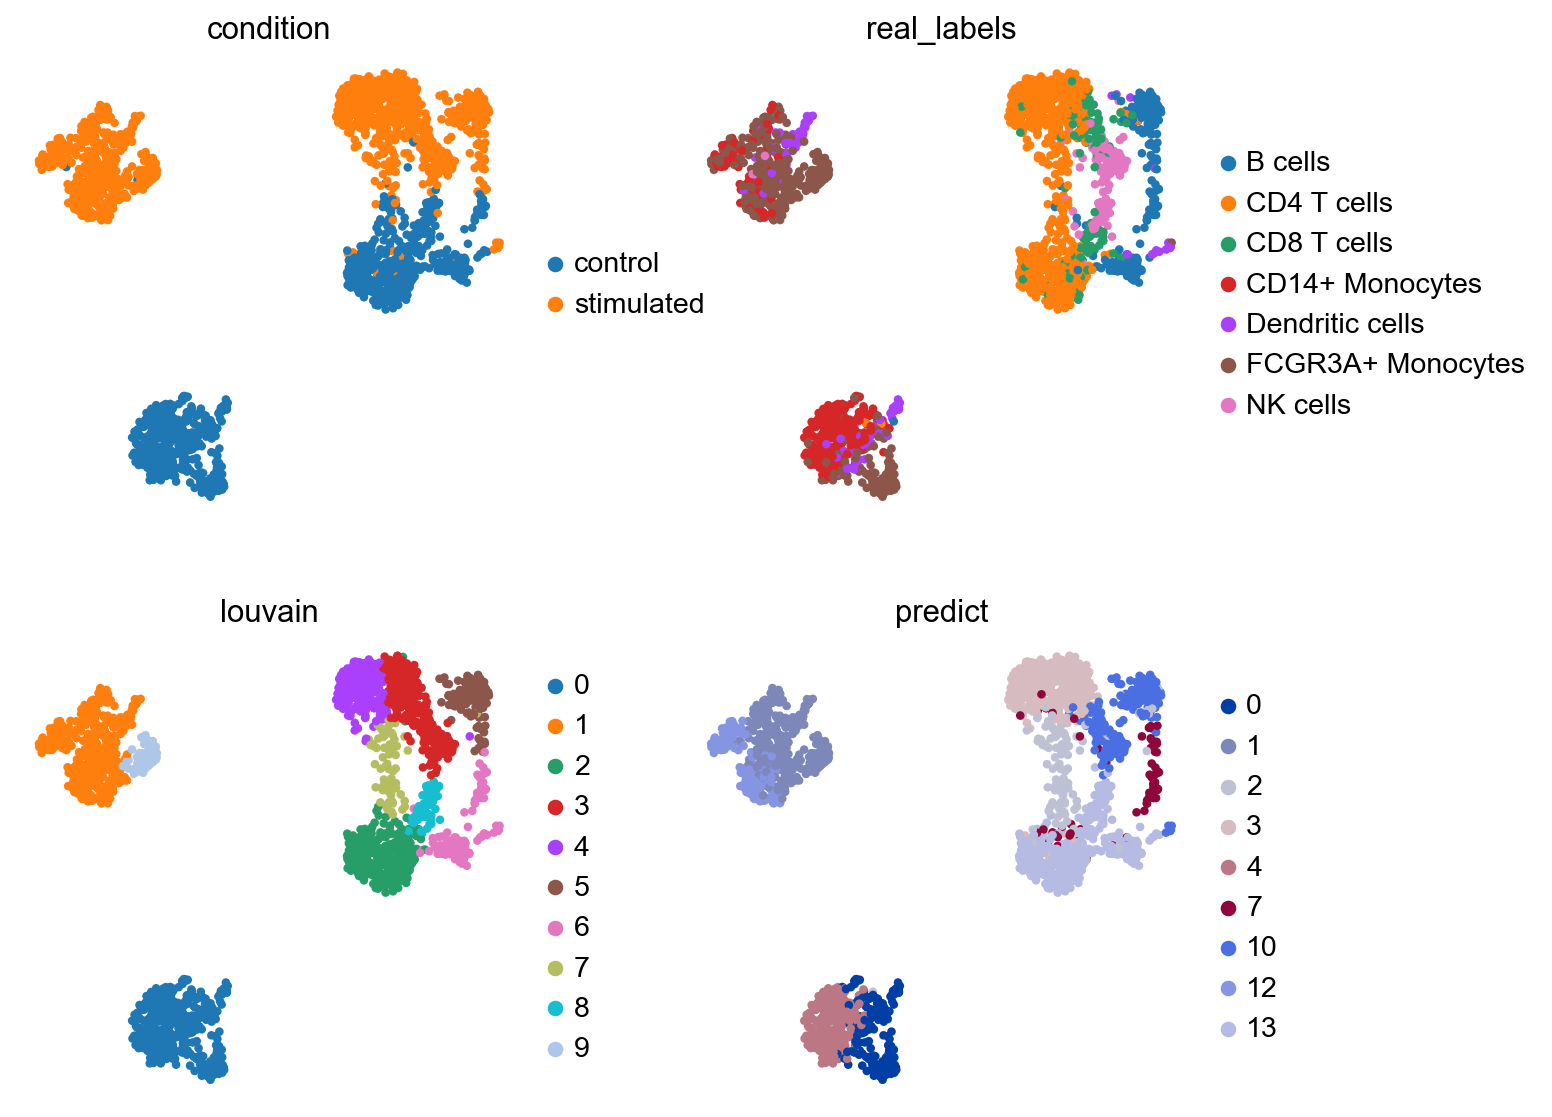

In [102]:
sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               "predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )

In [121]:
# now trying non clustering AEs and VAEs
reload(Mb0)
model = Mb0.AE_TypeB1500C(
    nx=bdata.n_vars,
    nc1=2,
    dropout=0.15,
    bn=True,
    reclosstype="mse",
)
model.apply(init_weights)
print(model.__class__)

True
<class 'gmmvaeBeta00.AE_TypeB1500C'>


In [123]:
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [data,
                labels,
                conditions,
                ],),
            batch_size=128,
            shuffle=True,
)
x, y, c = data__loader.__iter__().next()
Train.basicTrainLoopCond(
        model,
        data_loader,
        None,
        num_epochs=25,
        report_interval=35,
        lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        #test_accuracy=True,
        )
#y.shape
#c.shape
#x.shape
#model(x,cond1=c)
#model.Qz

epoch's lr =  0.001
epoch 0
training phase
rec: 1375.37646484375
total_loss: 1375.37646484375

epoch's lr =  0.001
epoch 0
training phase
rec: 193.1038818359375
total_loss: 193.1038818359375

epoch's lr =  0.001
epoch 0
training phase
rec: 176.33824157714844
total_loss: 176.33824157714844

epoch's lr =  0.0001
epoch 0
training phase
rec: 179.25274658203125
total_loss: 179.25274658203125

epoch's lr =  1e-05
epoch 0
training phase
rec: 177.49652099609375
total_loss: 177.49652099609375

done training


In [125]:
output = model(test_data, )
#bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
#bdata.obsm["w"] = output["w"].detach().numpy()
#bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#bdata.obsm["z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))
sc.pp.neighbors(bdata,use_rep="z")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical


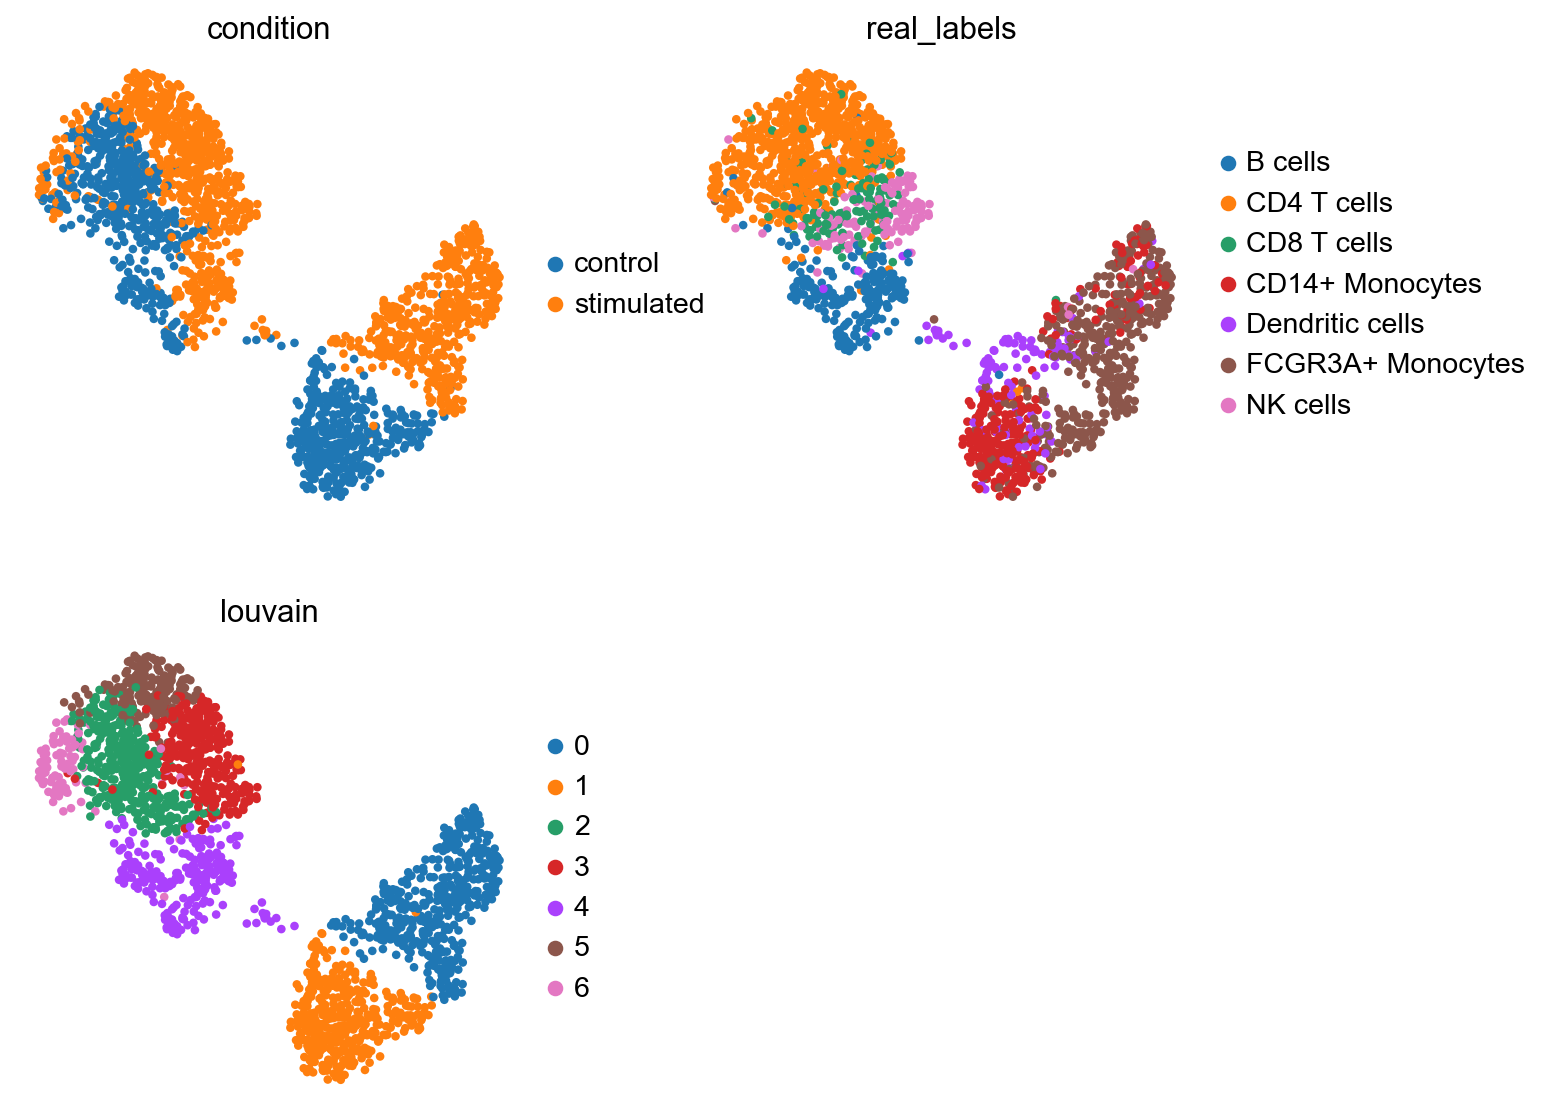

In [126]:
sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               #"predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )

In [129]:
reload(Mb0)
model = Mb0.VAE_AE_TypeB1500v(
    nx=bdata.n_vars,
    dropout=0.15,
    bn=True,
    reclosstype="mse",
    restrict_z=False,
)
model.apply(init_weights)
print(model.__class__)

data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSet(
            data,
            labels,
                ),
            batch_size=128,
            shuffle=True,
            )

True
<class 'gmmvaeBeta00.VAE_AE_TypeB1500v'>


In [130]:
Train.basicTrainLoop(
        model,
        data_loader,
        None,
        num_epochs=25,
        report_interval=25,
        lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        #lrs = [1e-4,1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        )


epoch's lr =  0.001
epoch 0
training phase
rec: 1352.3206787109375
loss_z: 49.26509094238281
total_loss: 1401.5858154296875

epoch's lr =  0.001
epoch 0
training phase
rec: 196.05581665039062
loss_z: 6.536017417907715
total_loss: 202.59182739257812

epoch's lr =  0.001
epoch 0
training phase
rec: 195.78741455078125
loss_z: 6.637972831726074
total_loss: 202.42538452148438

epoch's lr =  0.0001
epoch 0
training phase
rec: 196.39501953125
loss_z: 6.7560577392578125
total_loss: 203.1510772705078

epoch's lr =  1e-05
epoch 0
training phase
rec: 188.72845458984375
loss_z: 6.970433235168457
total_loss: 195.69888305664062

done training


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical


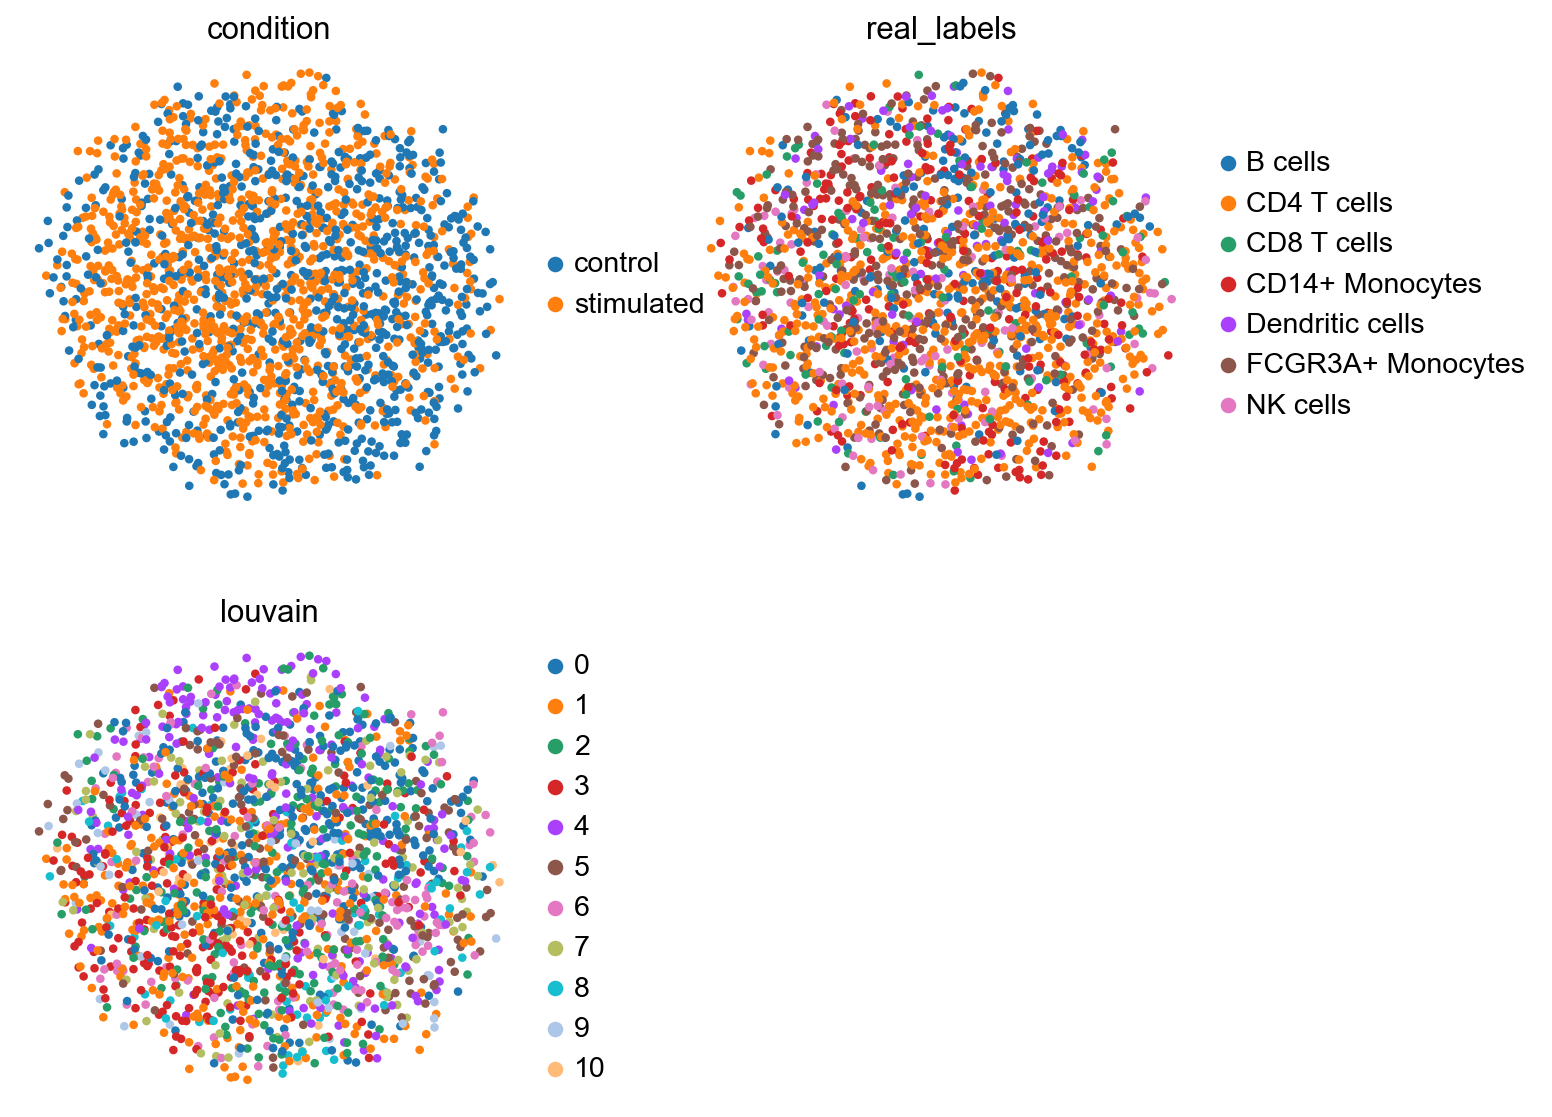

In [131]:
output = model(test_data, )
#bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
#bdata.obsm["w"] = output["w"].detach().numpy()
#bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#bdata.obsm["z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))
sc.pp.neighbors(bdata,use_rep="z")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               #"predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )

In [138]:
reload(Mb0)
model = Mb0.VAE_AE_TypeB1500vC(
    nx=bdata.n_vars,
    dropout=0.15,
    bn=True,
    reclosstype="mse",
    restrict_z=False,
    nc1=2,
    learned_prior=False,
)
model.apply(init_weights)
print(model.__class__)
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [data,
                labels,
                conditions,
                ],),
            batch_size=128,
            shuffle=True,
)
x, y, c = data__loader.__iter__().next()
Train.basicTrainLoopCond(
        model,
        data_loader,
        None,
        num_epochs=25,
        report_interval=35,
        lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        #test_accuracy=True,
        )


True
<class 'gmmvaeBeta00.VAE_AE_TypeB1500vC'>
epoch's lr =  0.001
epoch 0
training phase
rec: 1359.737060546875
loss_z: 46.216983795166016
total_loss: 1405.9541015625

epoch's lr =  0.001
epoch 0
training phase
rec: 201.22540283203125
loss_z: 5.657373428344727
total_loss: 206.88278198242188

epoch's lr =  0.001
epoch 0
training phase
rec: 200.55023193359375
loss_z: 5.670733451843262
total_loss: 206.22096252441406

epoch's lr =  0.0001
epoch 0
training phase
rec: 209.48577880859375
loss_z: 5.700675964355469
total_loss: 215.18646240234375

epoch's lr =  1e-05
epoch 0
training phase
rec: 187.1561279296875
loss_z: 6.215192794799805
total_loss: 193.37132263183594

done training


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical


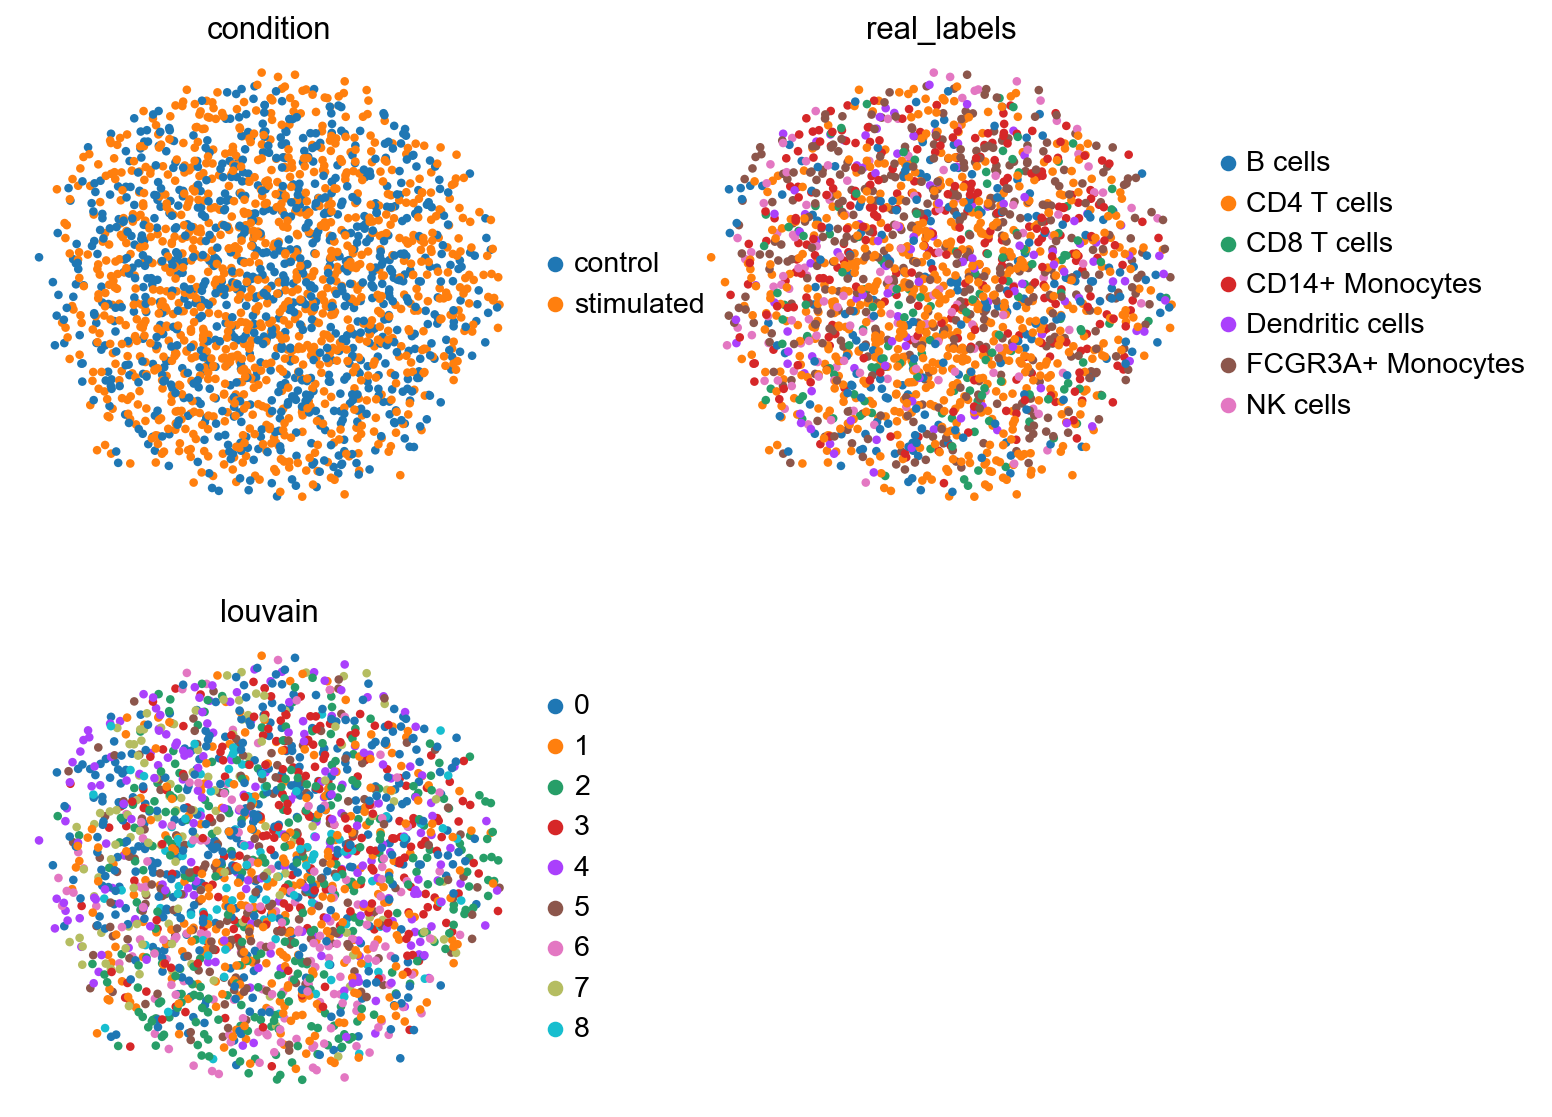

In [139]:
output = model(test_data, )
#bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
#bdata.obsm["w"] = output["w"].detach().numpy()
#bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#bdata.obsm["z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))
sc.pp.neighbors(bdata,use_rep="z")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               #"predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )


In [140]:
reload(Mb0)
model = Mb0.VAE_AE_TypeB1500vC(
    nx=bdata.n_vars,
    dropout=0.15,
    bn=True,
    reclosstype="mse",
    restrict_z=False,
    nc1=2,
    learned_prior=True,
)
model.apply(init_weights)
print(model.__class__)
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [data,
                labels,
                conditions,
                ],),
            batch_size=128,
            shuffle=True,
)
#x, y, c = data_loader.__iter__().next()
Train.basicTrainLoopCond(
        model,
        data_loader,
        None,
        num_epochs=25,
        report_interval=35,
        lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        #test_accuracy=True,
        )

True
<class 'gmmvaeBeta00.VAE_AE_TypeB1500vC'>
epoch's lr =  0.001
epoch 0
training phase
rec: 1376.876220703125
loss_z: 120.2151870727539
total_loss: 1497.0914306640625

epoch's lr =  0.001
epoch 0
training phase
rec: 211.40335083007812
loss_z: 5.605589866638184
total_loss: 217.00894165039062

epoch's lr =  0.001
epoch 0
training phase
rec: 209.9807586669922
loss_z: 5.674104690551758
total_loss: 215.6548614501953

epoch's lr =  0.0001
epoch 0
training phase
rec: 202.40554809570312
loss_z: 4.979401588439941
total_loss: 207.38494873046875

epoch's lr =  1e-05
epoch 0
training phase
rec: 191.35130310058594
loss_z: 5.423027992248535
total_loss: 196.7743377685547

done training


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical


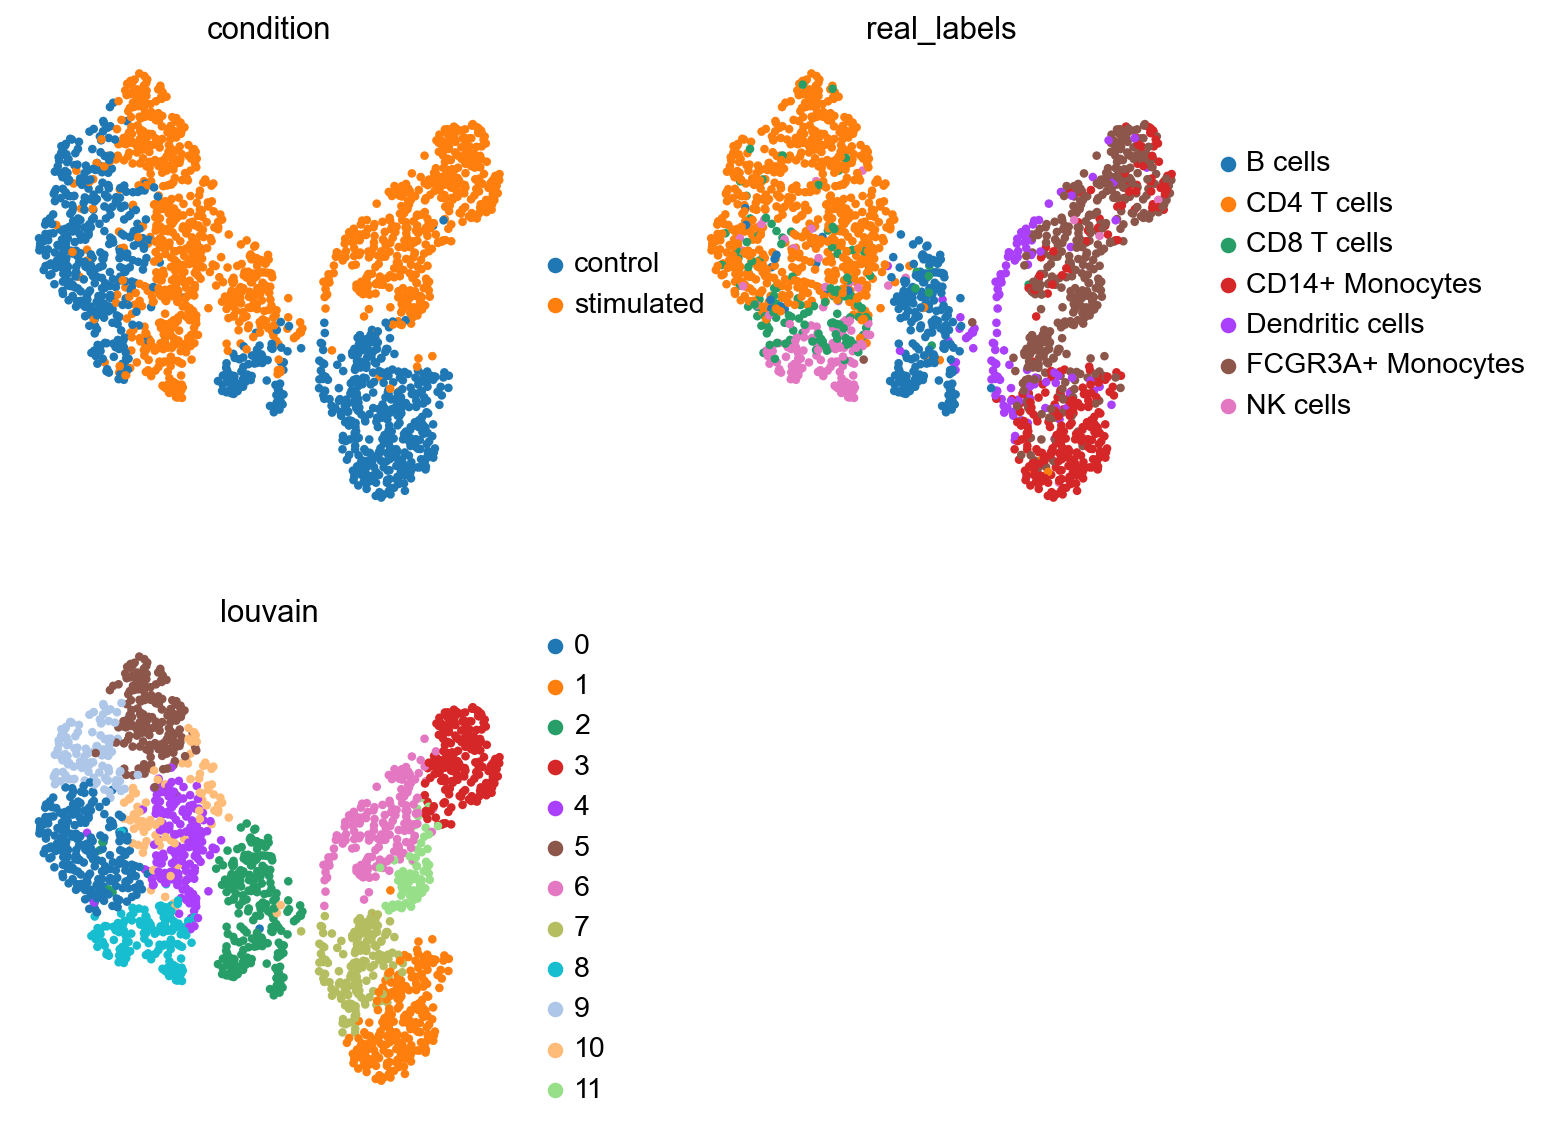

In [141]:
output = model(test_data, )
#bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
#bdata.obsm["w"] = output["w"].detach().numpy()
#bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#bdata.obsm["z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))
sc.pp.neighbors(bdata,use_rep="z")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               #"predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )


In [152]:
reload(Mb0)
model = Mb0.VAE_GMM_TypeB1603xz(
    nx=bdata.n_vars,
    nclasses=20,
    #wscale=0,
    #zscale=0,
    dropout=0.15,
    reclosstype="mse",
    #restrict_w=True,
    #restrict_z=True,
)
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                data,
                #conditions,
                labels,
                ],),
            batch_size=128,
            shuffle=True,
)
Train.basicTrainLoop(
        model,
        data_loader,
        None,
        num_epochs=25,
        report_interval=35,
        lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        #test_accuracy=True,
        )

True
epoch's lr =  0.001
epoch 0
training phase
rec: 1632.62060546875
loss_z: 18.00996971130371
loss_w: 3.8704721927642822
loss_cluster: -0.10563389211893082
loss_y: 0.03327968716621399
total_loss: 1654.534423828125
num_clusters: 0

epoch's lr =  0.001
epoch 0
training phase
rec: 209.06085205078125
loss_z: 2.652204990386963
loss_w: 0.9790521860122681
loss_cluster: -0.9843249320983887
loss_y: 0.942228376865387
total_loss: 213.63433837890625
num_clusters: 8

epoch's lr =  0.001
epoch 0
training phase
rec: 200.7449951171875
loss_z: 3.6069726943969727
loss_w: 1.0807738304138184
loss_cluster: -0.9930341243743896
loss_y: 1.0807044506072998
total_loss: 206.51345825195312
num_clusters: 7

epoch's lr =  0.0001
epoch 0
training phase
rec: 208.67196655273438
loss_z: 4.0253400802612305
loss_w: 0.490969717502594
loss_cluster: -0.99064040184021
loss_y: 1.0567468404769897
total_loss: 214.24502563476562
num_clusters: 7

epoch's lr =  1e-05
epoch 0
training phase
rec: 194.89830017089844
loss_z: 3.93224

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predict' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical


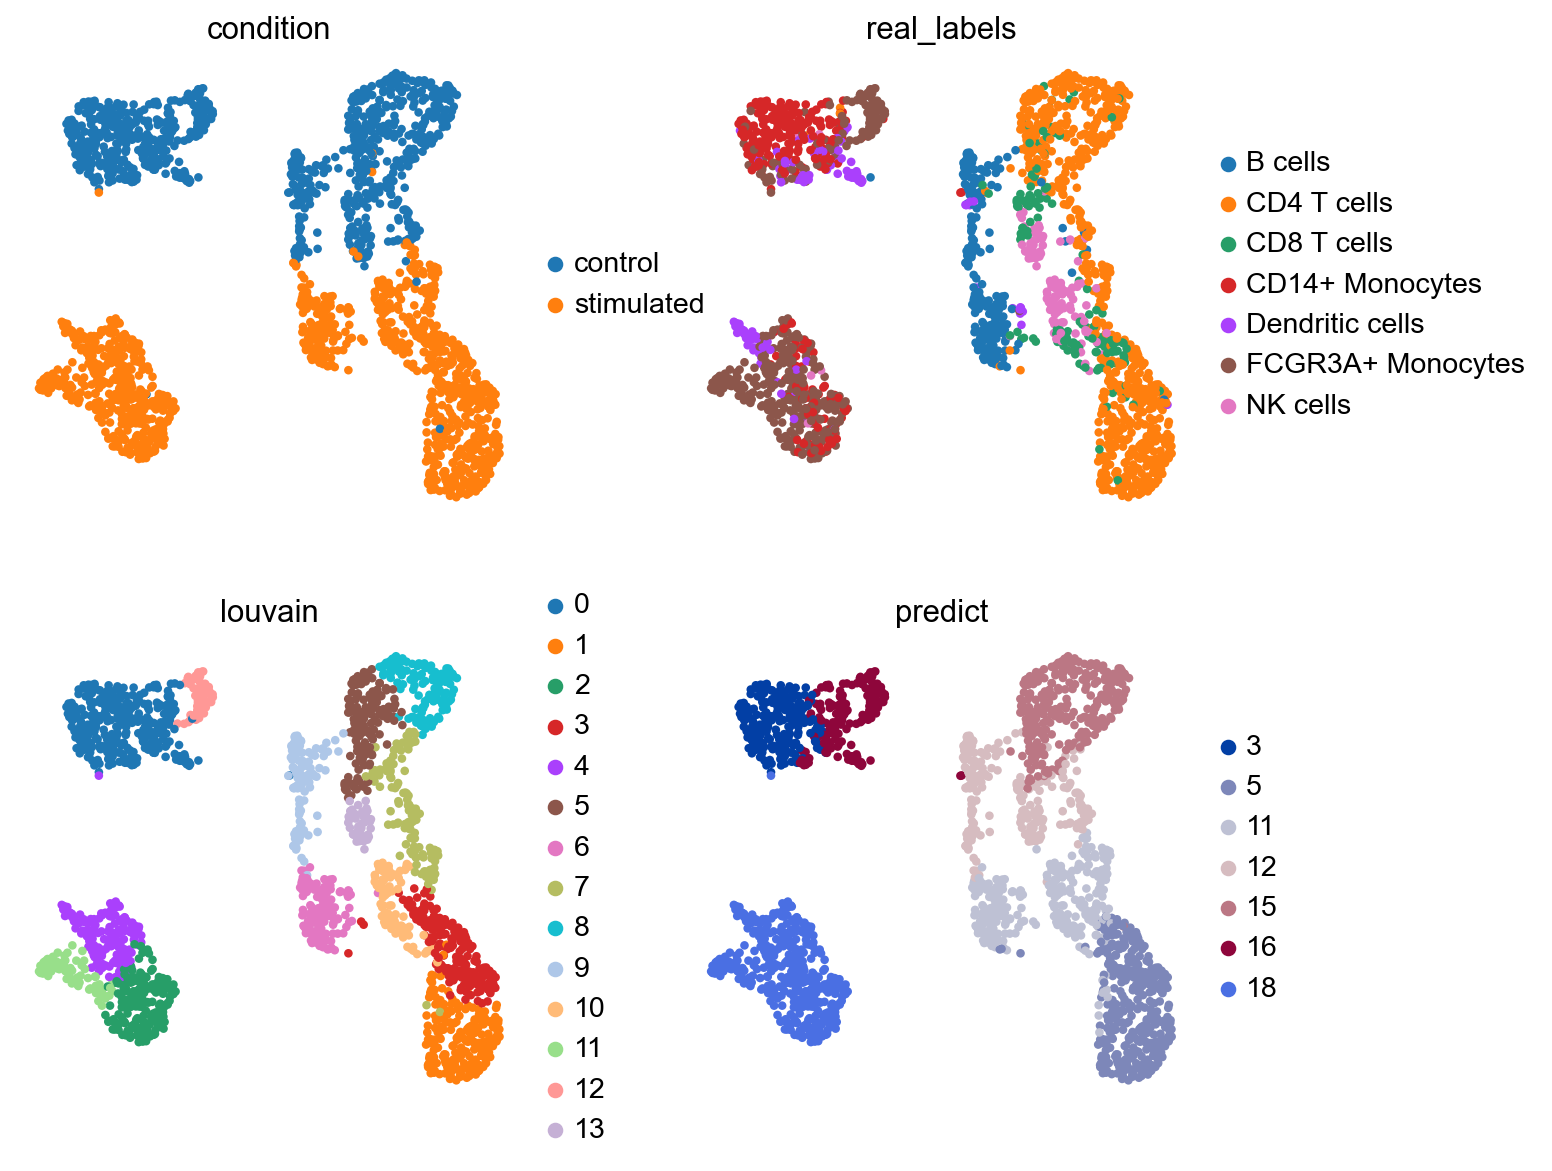

In [153]:
output = model(test_data, )
#bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
#bdata.obsm["w"] = output["w"].detach().numpy()
bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
bdata.obsm["z"] = output["mu_z"].detach().numpy()
#bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))
sc.pp.neighbors(bdata,use_rep="z")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               "predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )


In [154]:
reload(Mb0)
model = Mb0.AE_TypeB1500(
    nx=bdata.n_vars,
    reclosstype="mse",
    dropout=0.15,
)
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                data,
                labels,
                #conditions,
                ],),
            batch_size=128,
            shuffle=True,
)
Train.basicTrainLoop(
        model,
        data_loader,
        None,
        num_epochs=25,
        report_interval=35,
        lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        #test_accuracy=True,
        )


True
epoch's lr =  0.001
epoch 0
training phase
rec: 1637.0751953125
total_loss: 1637.0751953125

epoch's lr =  0.001
epoch 0
training phase
rec: 192.86135864257812
total_loss: 192.86135864257812

epoch's lr =  0.001
epoch 0
training phase
rec: 183.47940063476562
total_loss: 183.47940063476562

epoch's lr =  0.0001
epoch 0
training phase
rec: 174.54629516601562
total_loss: 174.54629516601562

epoch's lr =  1e-05
epoch 0
training phase
rec: 183.4842071533203
total_loss: 183.4842071533203

done training


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical


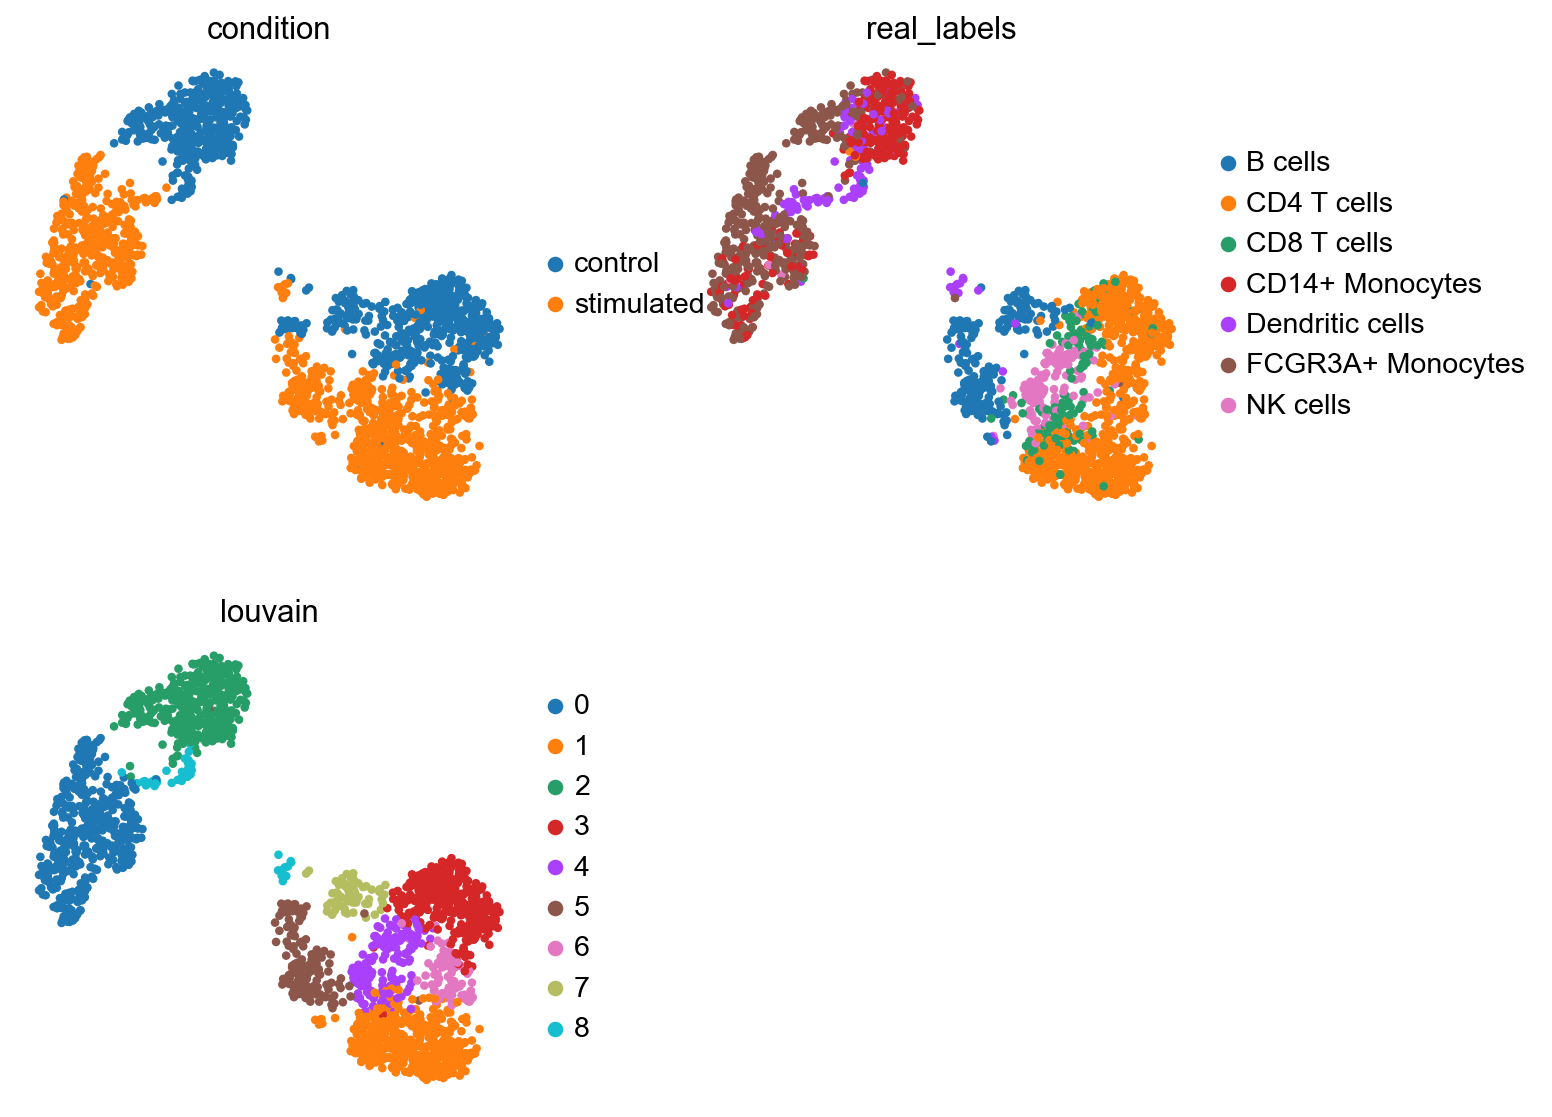

In [157]:
output = model(test_data, )
#bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
#bdata.obsm["w"] = output["w"].detach().numpy()
#bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#bdata.obsm["z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))
sc.pp.neighbors(bdata,use_rep="z")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               #"predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical


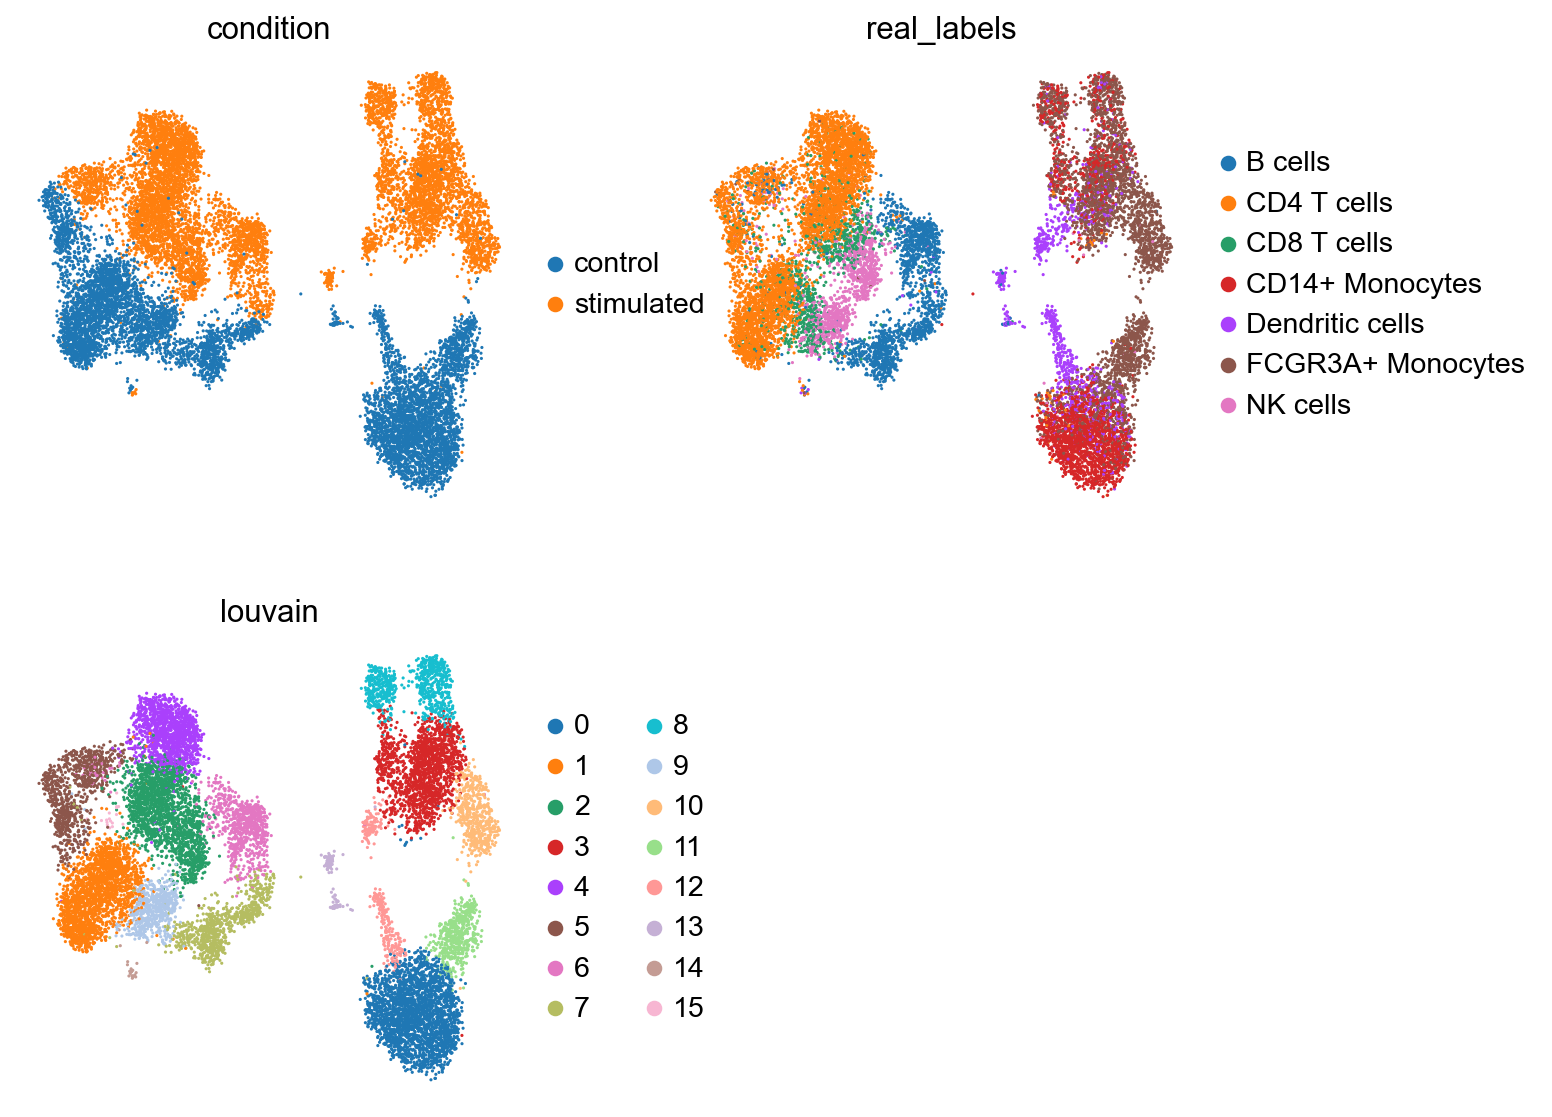

In [158]:
output = model(data, )
#bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
#bdata.obsm["w"] = output["w"].detach().numpy()
#bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#bdata.obsm["z"] = output["mu_z"].detach().numpy()
adata.obsm["z"] = output["z"].detach().numpy()
adata.obs["real_labels"] = enc_labels.inverse_transform(
        labels.argmax(-1))
sc.pp.neighbors(adata,use_rep="z")
sc.tl.umap(adata, )
sc.tl.louvain(adata,)

sc.pl.umap(adata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               #"predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )

In [160]:
reload(Mb0)
model = Mb0.VAE_TypeB1601(
    nx=bdata.n_vars,
    nz=10,
    nw=10,
    dropout=0.15,
    reclosstype="mse",
    restrict_w=False,
    restrict_z=False,
)
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                data,
                #conditions,
                labels,
                ],),
            batch_size=128,
            shuffle=True,
)
Train.basicTrainLoop(
        model,
        data_loader,
        None,
        num_epochs=25,
        report_interval=35,
        lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        #test_accuracy=True,
        )


True
epoch's lr =  0.001
epoch 0
training phase
rec: 1659.2310791015625
loss_z: 2.534717321395874
loss_w: 1.2311367988586426
total_loss: 1662.996826171875

epoch's lr =  0.001
epoch 0
training phase
rec: 213.3839111328125
loss_z: 3.473360776901245
loss_w: 2.1929759979248047
total_loss: 219.0502471923828

epoch's lr =  0.001
epoch 0
training phase
rec: 217.09735107421875
loss_z: 4.726842880249023
loss_w: 1.767404556274414
total_loss: 223.5915985107422

epoch's lr =  0.0001
epoch 0
training phase
rec: 213.04071044921875
loss_z: 4.619907379150391
loss_w: 1.6208887100219727
total_loss: 219.28150939941406

epoch's lr =  1e-05
epoch 0
training phase
rec: 199.65615844726562
loss_z: 4.336194038391113
loss_w: 1.7280964851379395
total_loss: 205.720458984375

done training


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical


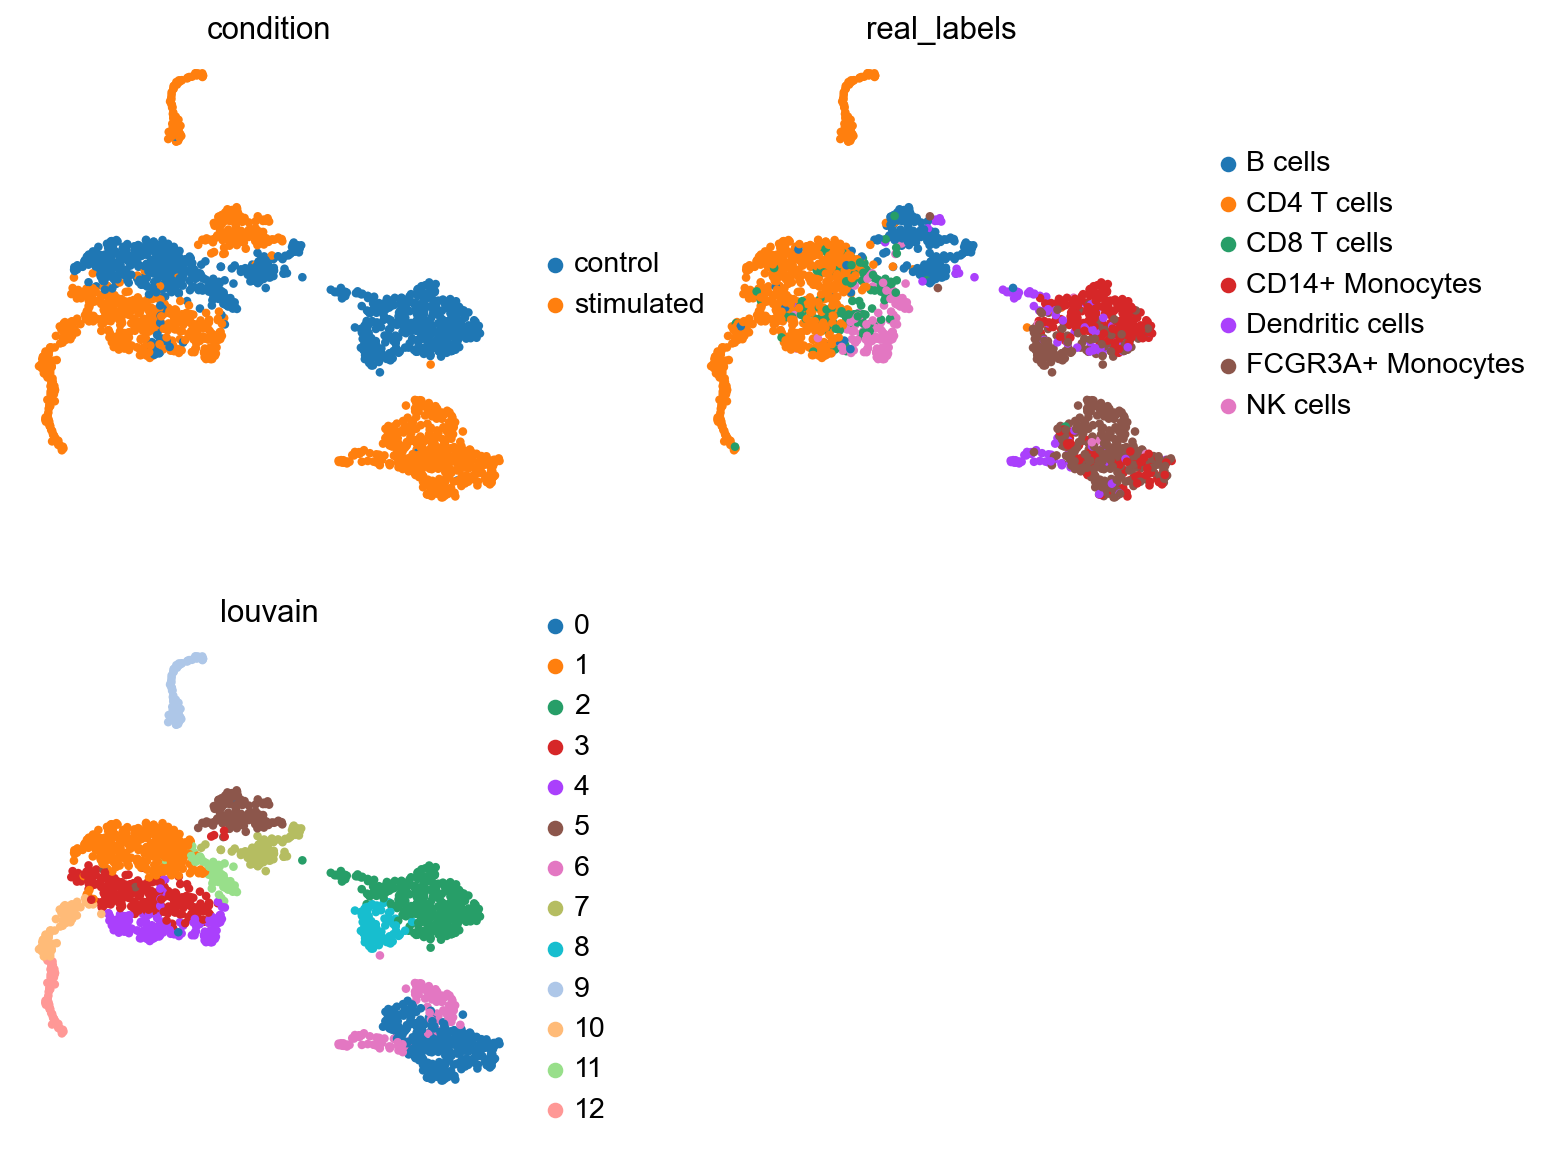

In [165]:
output = model(test_data, )
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()
#bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
bdata.obsm["mu_z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
#bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))
sc.pp.neighbors(bdata,use_rep="z")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               #"predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )


In [167]:
reload(Mb0)
model = Mb0.VAE_TypeB1601C(
    nx=bdata.n_vars,
    nz=10,
    nw=10,
    dropout=0.15,
    reclosstype="mse",
    restrict_w=False,
    restrict_z=False,
    nc1=2,
    learned_prior=False,
)
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                data,
                labels,
                conditions,
                ],),
            batch_size=128,
            shuffle=True,
)
Train.basicTrainLoopCond(
        model,
        data_loader,
        None,
        num_epochs=25,
        report_interval=35,
        lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        #test_accuracy=True,
        )


True
epoch's lr =  0.001
epoch 0
training phase
rec: 1653.5400390625
loss_z: 2.8589465618133545
loss_w: 1.416542649269104
total_loss: 1657.8154296875

epoch's lr =  0.001
epoch 0
training phase
rec: 216.959228515625
loss_z: 3.4083094596862793
loss_w: 1.413827896118164
total_loss: 221.7813720703125

epoch's lr =  0.001
epoch 0
training phase
rec: 193.46612548828125
loss_z: 3.760044574737549
loss_w: 1.4250328540802002
total_loss: 198.6511993408203

epoch's lr =  0.0001
epoch 0
training phase
rec: 196.0221405029297
loss_z: 4.515755653381348
loss_w: 1.382798433303833
total_loss: 201.9207000732422

epoch's lr =  1e-05
epoch 0
training phase
rec: 204.8137969970703
loss_z: 4.149540424346924
loss_w: 1.380624532699585
total_loss: 210.34396362304688

done training


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical


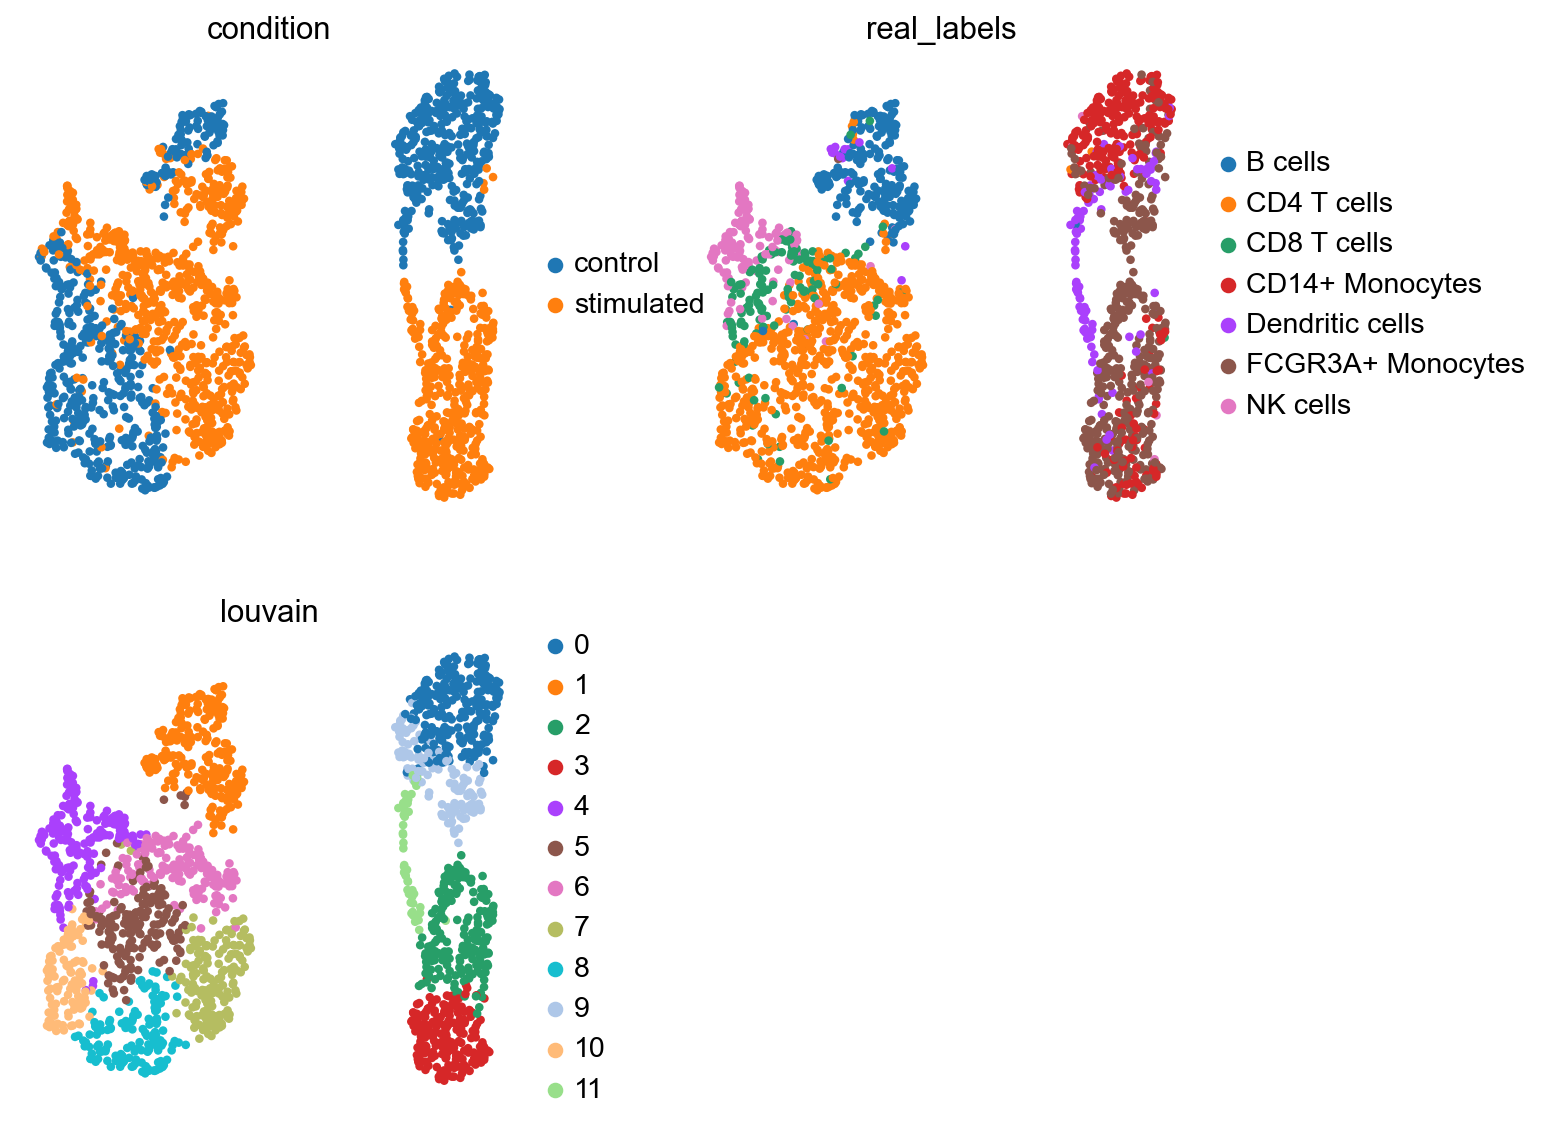

In [171]:
output = model(test_data, )
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()
#bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
bdata.obsm["mu_z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
#bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))
sc.pp.neighbors(bdata,use_rep="mu_z")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               #"predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )

In [172]:
reload(Mb0)
model = Mb0.VAE_TypeB1601C(
    nx=bdata.n_vars,
    nz=10,
    nw=6,
    dropout=0.15,
    reclosstype="mse",
    restrict_w=False,
    restrict_z=False,
    nc1=2,
    learned_prior=True,
)
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                data,
                labels,
                conditions,
                ],),
            batch_size=128,
            shuffle=True,
)
Train.basicTrainLoopCond(
        model,
        data_loader,
        None,
        num_epochs=25,
        report_interval=35,
        lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        #test_accuracy=True,
        )


True
epoch's lr =  0.001
epoch 0
training phase
rec: 1659.37841796875
loss_z: 3.033696413040161
loss_w: 2.0510759353637695
total_loss: 1664.463134765625

epoch's lr =  0.001
epoch 0
training phase
rec: 209.4971160888672
loss_z: 3.664545774459839
loss_w: 1.5705606937408447
total_loss: 214.7322235107422

epoch's lr =  0.001
epoch 0
training phase
rec: 202.84469604492188
loss_z: 3.2705624103546143
loss_w: 1.546095609664917
total_loss: 207.66136169433594

epoch's lr =  0.0001
epoch 0
training phase
rec: 212.86370849609375
loss_z: 4.261438369750977
loss_w: 1.5255320072174072
total_loss: 218.6506805419922

epoch's lr =  1e-05
epoch 0
training phase
rec: 186.27798461914062
loss_z: 4.434514045715332
loss_w: 1.4744560718536377
total_loss: 192.18695068359375

done training


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical


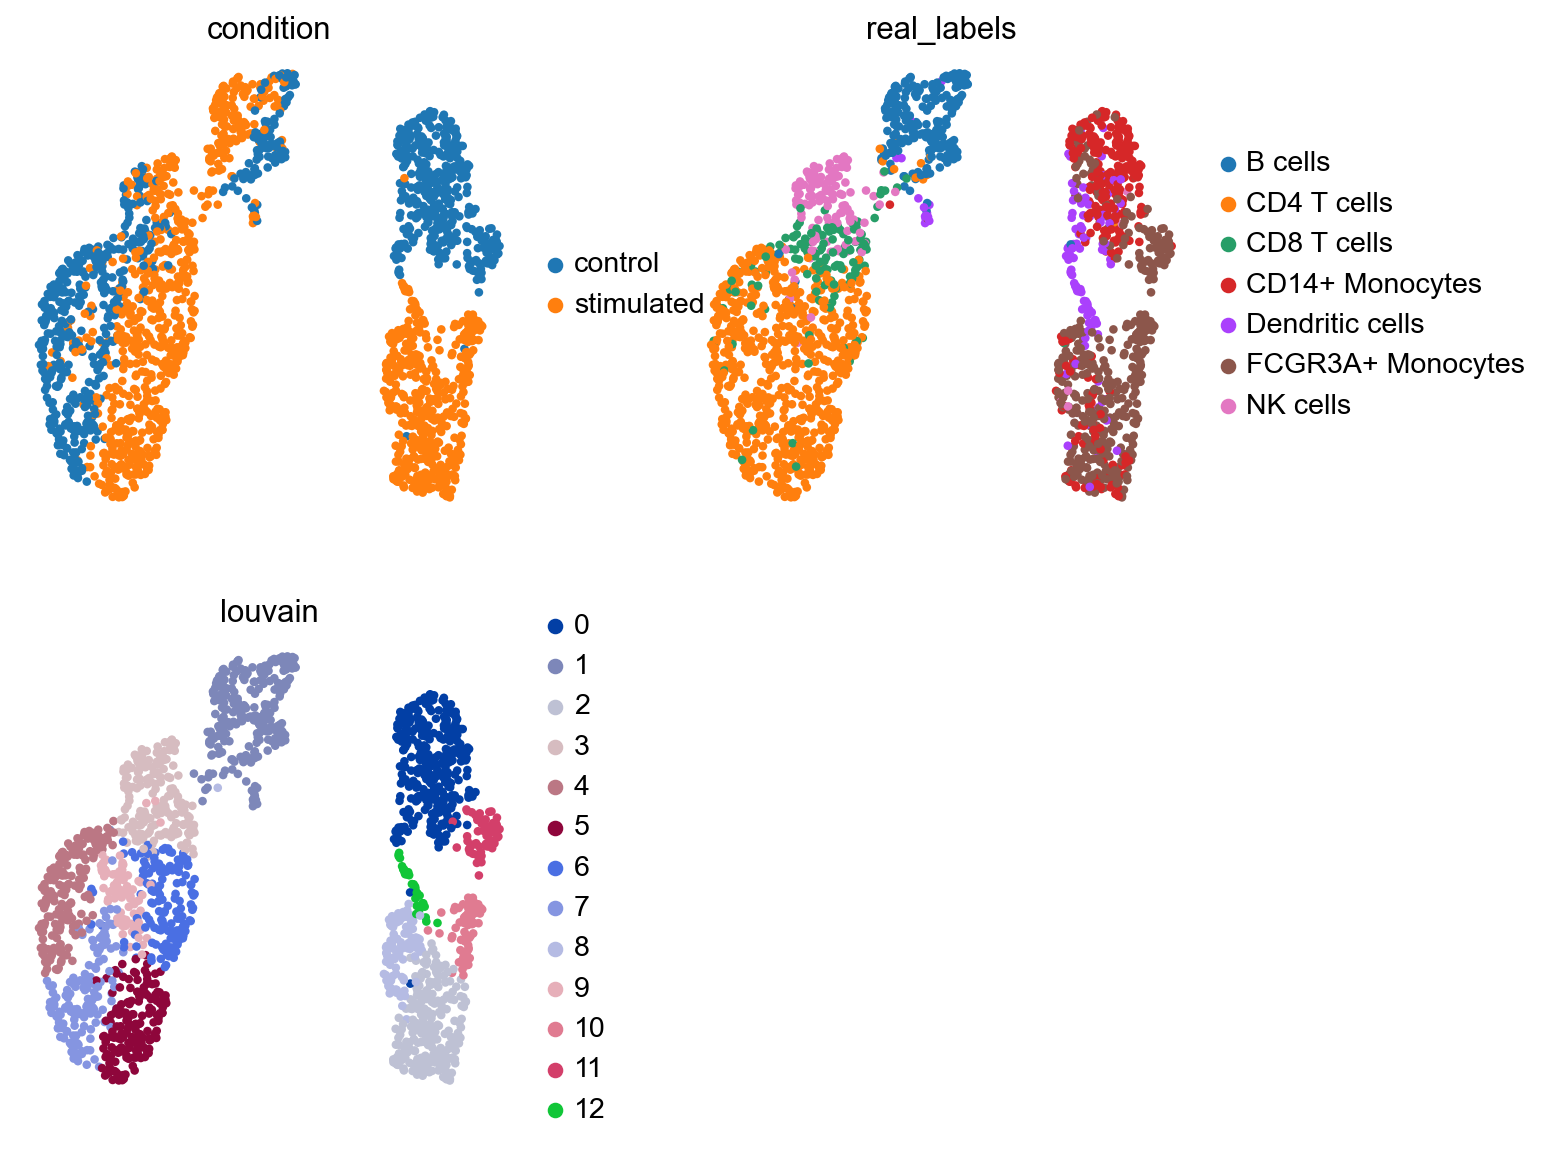

In [176]:
output = model(test_data, )
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()
#bdata.obs["predict"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
bdata.obsm["mu_z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
#bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))
sc.pp.neighbors(bdata,use_rep="mu_z")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               #"predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )


computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


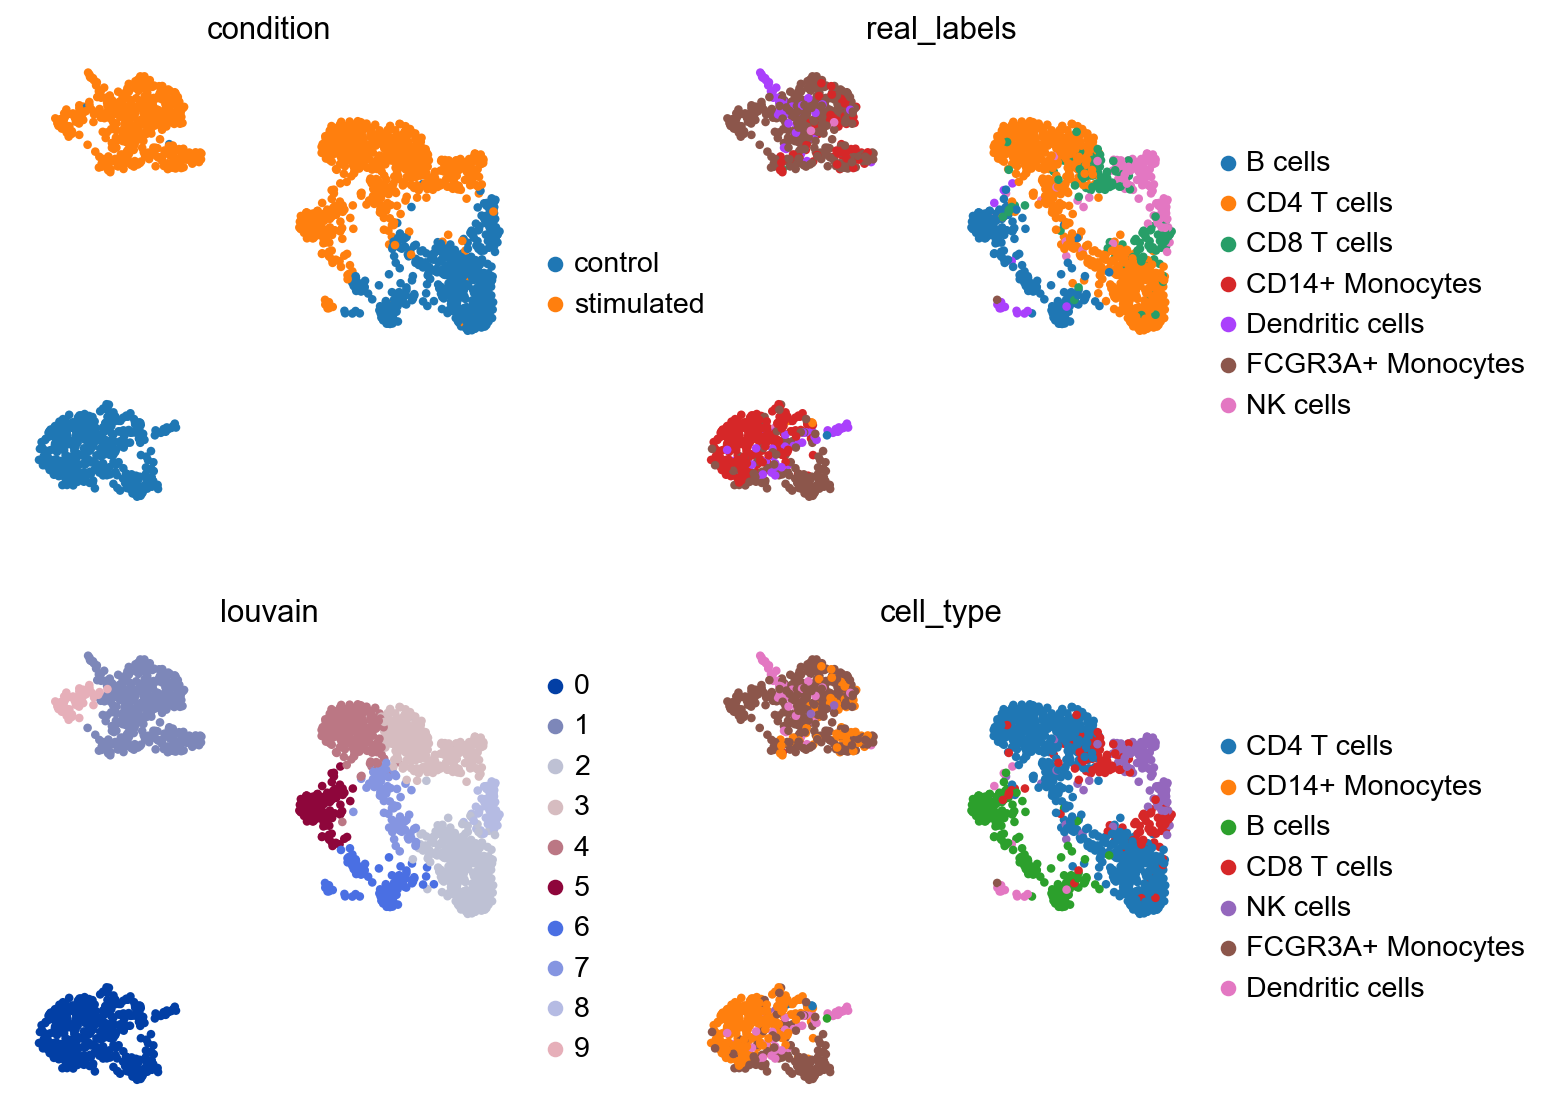

In [180]:
sc.pp.pca(bdata,)
sc.pp.neighbors(bdata,)
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

sc.pl.umap(bdata, 
           color=[
               "condition",
               "real_labels",
               "louvain",
               "cell_type",
               #"predict",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )
